In [4]:
import os
import sys

sys.path.append(f"{os.getcwd()}/..")

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from coconut import Coconut
import torch
from dataset import (
    get_dataset,
    get_question_latent_dataset,
    get_cot_latent_dataset,
    MyCollator,
)
import json
from tqdm import tqdm_notebook as tqdm
import re
import pandas as pd
pd.options.display.max_colwidth = 100

In [6]:
model_cot = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
saved_weights = torch.load(
    'checkpoints/gsm-cot/checkpoint_15', map_location=torch.device(0)
)
model_cot.load_state_dict(saved_weights, strict=False)
model_cot = model_cot.to(0)

tokenizer_cot = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer_cot.pad_token = tokenizer_cot.eos_token
model_cot.generation_config.pad_token_id = tokenizer_cot.pad_token_id

/tmp/ipykernel_7767/4241707443.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_weights = torch.load(


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/gsm-cot/checkpoint_15'

In [ ]:
with open('data/gsm_test.json') as f:
    test_data = json.load(f)

In [ ]:
test_data[0]

{'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
 'steps': ['<<16-3-4=9>>', '<<9*2=18>>'],
 'answer': '18'}

In [ ]:
N_SEQUENCES = 15

In [ ]:
output_data = []
for q_idx, d in enumerate(tqdm(test_data)):
    question = d['question']
    anwser = d['answer']
    tokens = tokenizer_cot(d['question'])
    output = model_cot.generate(
        torch.tensor(tokens['input_ids'], device='cuda:0').unsqueeze(0),
        attention_mask=torch.tensor(tokens['attention_mask'], device='cuda:0').unsqueeze(0),
        max_new_tokens=60,
        num_beams=N_SEQUENCES,
        num_return_sequences=N_SEQUENCES,
        # temperature=0.1,
        # do_sample=True,
    )
    steps_seen = set()
    for a_idx, out in enumerate(output):
        output_str = tokenizer_cot.decode(out)
        print(output_str)
        steps = ','.join(re.findall(r"<<(.+)>>", output_str))
        if steps in steps_seen:
            break
        steps_seen.add(steps)
        output_awser = ','.join(re.findall(r"###\s*([0-9]+)\s*<\|endoftext\|>", output_str))
        output_data.append([q_idx, f"{q_idx}_{a_idx}", question, anwser,
                       steps, output_awser, anwser==output_awser, output_str])

/tmp/ipykernel_136345/260438643.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for q_idx, d in enumerate(tqdm(test_data)):


  0%|          | 0/1319 [00:00<?, ?it/s]

In [ ]:
output_df = pd.DataFrame(
    output_data,
    columns=['q_idx','qa_idx','question','true_anwser','pred_steps','pred_anwser','correct_anwser','raw_output']
)

In [ ]:
output_df

,q_idx,qa_idx,question,true_anwser,pred_steps,pred_anwser,correct_anwser,raw_output
0,0,0_0,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...,18,"3+4=7,16-7=9,9*2=18",18,True,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...
1,0,0_1,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...,18,"3+4=7,16-7=9,9*7=63,63*2=126",126,False,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...
2,0,0_2,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...,18,"3+4=7,16-7=9,16*9=144,144*2=288",288,False,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...
3,0,0_3,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...,18,"16-3=13,3+4=7,13-7=6,6*2=12",12,False,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...
4,0,0_4,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...,18,"3+4=7,16-7=9,9*4=36,36*2=72",72,False,Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins ...
...,...,...,...,...,...,...,...,...
10036,1318,1318_0,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...,14,"7*8=56,56/4=14",14,True,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...
10037,1318,1318_1,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...,14,"7*8=56,1+3=4,56/4=14",14,True,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...
10038,1318,1318_2,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...,14,"1+3=4,7*8=56,56/4=14",14,True,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...
10039,1318,1318_3,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...,14,"1+3=4,56/4=14",14,True,Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry a...


In [ ]:
#output_df = pd.read_csv('data/cot_pos_neg.csv')

In [ ]:
# Remove examples with dumb steps
dumb_ops = output_df['pred_steps'].str.contains(r'\*1=|\*0=|\+0=', na=False)
output_df_filtered = output_df[~dumb_ops]

# Remove examples that don't have a correct exampels
gb = output_df_filtered.groupby('q_idx')['correct_anwser'].sum()
gb = gb[gb>0]
output_df_filtered = output_df_filtered[output_df_filtered['q_idx'].isin(gb.index)]

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

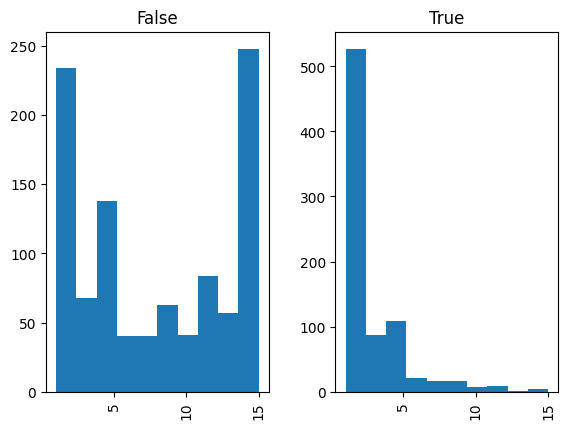

In [ ]:
output_df.groupby(['q_idx', 'correct_anwser']).size().hist(by='correct_anwser')

In [ ]:
output_df.groupby('correct_anwser').size()

correct_anwser
False    7982
True     2059
dtype: int64

In [ ]:
output_df.to_csv('data/cot_pos_neg.csv', index=False)
output_df_filtered.to_csv('data/cot_pos_neg_filtered.csv', index=False)

In [ ]:
output_df.iloc[10036]['question']

'Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?'